GitHub: https://github.com/vidisha04/02467-CSS.git
Group Members:
* Vidisha Sinha: s204081
* Mads Andersen: s204137

# Part 1 - Webscraping the 2019 poster and oral presentations
We have to scrape the oral and poster sessions web-page while answering the following questions:
1) Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.
2) How many unique researchers you got in 2019?
3) Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

In [1]:
#Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm.notebook import tqdm
import json
import yaml
import numpy as np
from csv import DictWriter

### 1) Scraping the oral presentations
For this session it can be seen from the html that each presentation is marked with the ```<br>``` tag and for finding every presentation the ```soup.findall()```  function can be used. Furthermore after inspecting the list, it can be seen that the first 9 instances are not researchers so they are cut out and the printout of the list is commented out since it is quite long. In the end, a small subset of the list of researches is printed to give an idea of what the format is.

In [2]:
url = "https://2019.ic2s2.org/oral-presentations/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

researchers = soup.find_all("br")
researchers = [i.previous_sibling for i in researchers]

#print(researchers)
researchers = researchers[9:] #Some tags in the beginning are included which can simply be cut out
researchers[:3]

[<em>Chair: Ziv Epstein</em>,
 '11:00 – 11:15 – Jieyu Ding, Qiusi Sun, Jingwen Zhang. Classifying and Understanding the Semantic Structures of Vaccine Misinformation on Twitter',
 '11:15 – 11:30 – Mahmoudreza Babaei, Juhi Kulshrestha, Abhijnan Chakraborty, Elissa M. Redmiles, Meeyoung Cha, Krishna Gummadi. Analyzing Biases in Perception of Truth in News Stories and Their Implications for Fact Checking']

Now some formatting have to be done by splitting on punctuations "." and dashes "-". By using the ```.split()``` method on a string, which produces a list of the splits. One obvious drawback of this is that names containing abbreviations will get split into two elements. In order to separate the timestamps it was checked if the element contained ":" since this is quite unlikely to be in a authorname at the same time get rid of the empty strings.

In [3]:
d = [str(i).split('.') for i in researchers]
d = [i[0] for i in d]
d = [i.split(' – ') for i in d]

dt = []
for i in d:
  for j in i:
    if ':' not in j and j != '':
      dt.append(j)

d = [i.split(',') for i in dt]
d = [item[1:] if item[0] == ' ' else item for sublist in d for item in sublist]
d = list(set(d)) # In order to remove duplicates a set of the list can be used

From this a list of the author names are made, however the titles still needs to be removed from the list as can be seen in the subset belowe.

In [4]:
d[:9]

['Vincenz Frey',
 'Ali Hürriyetoğlu',
 'Abigail Horn',
 'Nicos Nicolaou',
 'Yannick Léo',
 'Fırat Duruşan',
 'Bernardo Garcia Bulle',
 'Yerka Freire-Vidal',
 'Dr']

Because of this, we can make the assumption that if any "author-name" is longer than 4 words it will be classified as it as a title and removed from the list. One important thing is that it is how many words/names are contained and not characters.

In [5]:
oral_presenters = d.copy()

In [6]:
name_length = lambda x: len(x.split(' '))

oral_presenters = [name for name in oral_presenters if name_length(name) < 4]
oral_presenters = list(set(oral_presenters))

Now check if the list again, the ```set()``` data structure is used to remove duplicates. Of course, two authors could have the same name, but there is no good way to deal with this issue.

In [7]:
s = f'Number of oral presenters:{len(oral_presenters)}'
print(s)

Number of oral presenters:458


### Scraping the poster session
For this html file every presenter was marked with the ```<li>``` tag, again the ```find_all()``` method from the BeautifulSoup package is used. That creates a messy list which needs cleaning. First, each element in the list is checked to see if it contains the ```<span>``` tag, since every list of presenters was marked with that. Simultaneously, new line markers and tab markers are removed by replacing them with empty strings.

In [8]:
url = "https://2019.ic2s2.org/posters/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

researchers = soup.find_all("li")
researchers = [i.text.strip().replace("\n", "").replace("\t", "") for i in researchers if i.find("span")]

As said, this gives quite a messy list with a lot of artifacts from the html file. The code below removes these. By visual inspection, the first 4 elements are not useful so they are cut out. Furthermore, the titles are marked with \xa0 *(see codecell below)* so each string will is split up on that tag and then the title is removed *(line one)*. After this the strings a basically split up as before on the "," and now also "and" while also removing whitespaces in the front and back of the strings.

In [9]:
# Show the \xa0 marker.
researchers[4]

'Frank Peter Pijpers\xa0Hypothesis testing of causality between time series'

In [10]:
d = [i.split('\xa0')[0] for i in researchers][4:]
d = [i.split('and') for i in d]
d = [item for sublist in d for item in sublist]
d = [i.split(',') for i in d]
d = [item for sublist in d for item in sublist if item != '']
# One last clean up for empty spaces in the end or beginnig of a word
d = [name[1:] if name[0] == ' ' else name for name in d]
# Do the same for the names ending with white space
d = [name[:-1] if len(name) >1 and name[-1] == ' ' else name for name in d]
d = list(set(d)) #remove dublicates using set()

In [11]:
#Get the length of the list
len(d)

443

### 2) How many unique authors total?
This gives a total of 823 unique authors for the 2019 conference.

In [12]:
ic2s2 = list(set(d+oral_presenters))
len(ic2s2)

823

### 3) Choices for the webscraping
One of the already mentioned choices which was made was to split the strings on "." for the oral presentations. This meant that some names were split into two, and that would mean that an extra author was added to the list. Another decision which was made was to remove "names" with a length bigger than 3 since this would likely be a title and not a name. The drawbacks of this decision is that some author names could be more than 3 words, and on the other hand some titles could be less than 3 words, meaning the descission could either add or reduce the amount of authors found for the conference.

# Part 2: Getting data from the Semantic Scholar API

First load the id's which was saved into json file, and then convert it to a dictionary. Note that if the author could not be found it was simply marked it with "not found".

In [5]:
author_database = pd.read_json('/Users/madsandersen/CompSocialScience/02467-CSS/all_authors.json', typ='series').to_dict()

In [6]:
n_authors_total = len(set(list(author_database.keys())))

### Get the paper and the the other required entrances
We choose to do a subset due to resource limitations. However the code demonstrates how the querying could be done, given enough time. Note that there is a 100 request limitation per 5 min, which is why a counter is initialized and incremented everytime a request is made to the server. When the limitation is reached the time module is used to make the loop wait for 5 minutes. To be on the safe side the number of requests is set to 95 and 10 seconds are added to the timer pause.

Exercises which needs to be solved
1) Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.
2) Share the code you have used to solve the exercise above. (See code cell below)
3) How long is your final Author dataframe? How long is your final Paper dataframe?


### 1)
The data-base of authors which was created, was 112,000 authors in total so this is all the authors from IC2S2 and all of their collaborators in other projects. To be more specific this means the 2019,2020,2021 and 2022 editions of the IC2S2 conferences was considered.
 For this exercise only a subset of size 10,000 were considered, in order to keep the running time reasonable the 10,000 samples were randomly chosen with seed 42

### 2) Code for generating data-sets
The following code cells generates the 3 data-sets. Above each cell there is a short description of what the code does.

In [19]:
np.random.seed(42)

In [20]:
# To keep the private api keep safe, we stored in a different file:
with open('api_key.yaml') as f:
    api_key_dict = yaml.safe_load(f)

The code in these cells, samples the authors from the author-database and loads the api key. The next cell initializes the three csv files that will be used to create the data-frames.

In [21]:
n_authors = 10000
ind = np.random.choice(list(author_database.keys()),n_authors,replace = False)
api_key = api_key_dict['api_key']

In [22]:
def init_csv(name,columns):
    with open(name,'w') as f:
        f.write(','.join(columns))
        f.write("\n")

Now the three csv files are initialized, note that these will then be loaded as pandas dataframes, this was an easy way to iterably update the files, such that if the loop failed for some reason, the loop could simply be started from where it ended without having to overwrite the old files.

In [23]:
# Initialize the 3 csv files
init_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Author_dataset.csv',['authorId','name','aliases','citationCount','field'])
init_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Paper_dataset.csv',['paperId','title','year','DOI','citationCount','fields','authorIds'])
init_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Abstract_dataset.csv',['paperId','abstract'])

This cell is responsible for writing a line of data to the csv file, using the ```DictWriter``` class

In [24]:
def write_to_csv(dict,data_set_name):
    """ Takes a dictionary with the information to write to the csv"""
    col_names = list(dict.keys())
    if data_set_name == 'abstract':
        path = '/Users/madsandersen/CompSocialScience/02467-CSS/Abstract_dataset.csv'
    elif data_set_name == 'author':
        path = '/Users/madsandersen/CompSocialScience/02467-CSS/Author_dataset.csv'
    elif data_set_name == 'paper':
        path = '/Users/madsandersen/CompSocialScience/02467-CSS/Paper_dataset.csv'
    else:
        raise("Not a dataset type")

    with open(path, 'a') as f_object:
        dict_writer = DictWriter(f_object, fieldnames=col_names)
        dict_writer.writerow(dict)

The function below is a helper function for creating paper dataset, and also the abstract dataset. It loops through the collection of papers given to it, and distributes the information into the correct dataframes. Beyond this it checks if the paper already exists in the data-set such that replicas are avoided. Some of the fields do need to have an option for a none value, since the api will not return anything if the field does not exist for the author. For the author ids a list is made of all the authors, and the it is joined into a single string. This is done so that it becomes easier to parse to a dataframe, and since the id's are seperated with a "," it is easy to get a list of them when working with the dataframe using the .split() string method.
Another thing to mention is the fact that a dataframe is created for each row, and then appended to the final dataset.

In [25]:
def write_paper_data(papers):
  d = {}
  a = {}
  for i,paper in enumerate(papers):
    #if paper['paperId'] not in Paper_dataset['paperId']:
    d['paperId'] = paper['paperId']
    d['title'] = paper['title']
    d['year'] = paper['year']
    d['DOI'] = paper['externalIds']['DOI'] if 'DOI' in paper['externalIds'].keys() else None
    d['citationCount'] = paper['citationCount']
    d['fields'] = [field['category'] for field in paper['s2FieldsOfStudy']] if len(paper['s2FieldsOfStudy']) != 0 else [None]
    d['authorIds'] = [au['authorId'] for au in paper['authors']]

    # Create the abstract data-set
    a['paperId'] = paper['paperId']
    a['abstract'] = paper['abstract']

    # Write to paper-dataset
    write_to_csv(d,'paper')

    # Write to abstract
    write_to_csv(a,'abstract')

The code below is where the query takes place. First, the fields are defined ie. what should be queried for. Next thing is to loop through all authors being considered where the querying is done using their author id and the returned object is then converted into a json object so that it can be accessed as a dictionary. Most of the required fields is just copying them into a dict, which can then be written to a csv file.

For the citation count, each author's paper has to be iterated and the citation count can be done as sum of the list of citation counts. For the most frequent field of study, all the fields of studies the author has been involved in, is made in to a list, and the most frequent element in that list is found.

Also the previously defined and described functions are called in order to write the paper-dataset and the abstract dataset. The code also pauses for 1 sec every 98 iterations, this was not done to prevent the api from exceeding the limit but because the pc that queried and wrote to the csv's had a tendency of crashing, so by pausing this helped the issue.

Note:
Our group got an api key for 100 req/sec for the semanthic scholar api. It can't be distributed so either paste in your own api-key or delete the lines with headers and as an argument in the request call.

In [26]:
#How many authors should be considered in the dataset
fields = f'name,aliases,papers.title,papers.abstract,papers.year,papers.s2FieldsOfStudy,papers.citationCount,papers.paperId,papers.externalIds,papers.authors'

exception_counter = 0
query_counter = 0
total_queries = 0
for id in tqdm(ind):
  au_dict = {} # A dict which stores authors data.
  if id == 'not found':
    continue
  try:
    my_url = f'https://api.semanticscholar.org/graph/v1/author/{id}?fields={fields}' #BASE_URL + VERSION + RESOURCE
    params = {'authorId': id}
    headers = {"x-api-key": api_key}
    r = requests.get(my_url, params=params,headers=headers).json()
    query_counter += 1
    total_queries += 1

    #############################Author_dataset##########################################
    au_dict['authorId'] = id
    au_dict['name'] =  r['name']
    au_dict['aliases'] = ','.join(r['aliases']) if r['aliases'] is not None else 'None'
    au_dict['citationCount'] = sum([paper['citationCount'] for paper in r['papers']])
    # Make a placeholder, so the most frequent can be determined:
    l = [paper['s2FieldsOfStudy'][0]['category'] if len(paper['s2FieldsOfStudy']) != 0 else None for paper in r['papers']]
    freq_field = max(set(l), key = l.count)
    au_dict['field'] = freq_field
    # Write the author to csv.
    write_to_csv(au_dict,'author')

    ###########################Paper_dataset ##########################################
    write_paper_data(r['papers'])

  except:
    print(f"Exception caught for author:{id}")
    exception_counter += 1
    time.sleep(1)

  if query_counter > 98:
    time.sleep(1)
    query_counter = 0

  0%|          | 0/10000 [00:00<?, ?it/s]

Exception caught for author:103003475
Exception caught for author:120952273
Exception caught for author:50053230
Exception caught for author:31549868
Exception caught for author:98801405
Exception caught for author:3317894
Exception caught for author:2149407811
Exception caught for author:144007706
Exception caught for author:103510843
Exception caught for author:46453897
Exception caught for author:117948691
Exception caught for author:116528349
Exception caught for author:103772254
Exception caught for author:152229342
Exception caught for author:143877954
Exception caught for author:50203686
Exception caught for author:92075785
Exception caught for author:95026113
Exception caught for author:40005364
Exception caught for author:145540917
Exception caught for author:144551711
Exception caught for author:145412420
Exception caught for author:113344138
Exception caught for author:32218642
Exception caught for author:7402177
Exception caught for author:102336607
Exception caught for aut

Read the csv files from the data-set created as pandas dataframes, and then drop the duplicate values from the dataframe.

In [28]:
Author_dataset = pd.read_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Author_dataset.csv')
Paper_dataset = pd.read_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Paper_dataset.csv')
Paper_dataset.drop_duplicates(subset = ['paperId'], keep = 'first',inplace = True)

### 3) Length of the dataframes
Below the lengths of the dataframes are displayed, there is a little fewer than 10,000 in the author dataframe because some could not be found or some error happened while querying.

In [31]:
pd_length = len(Paper_dataset['paperId'])
au_length = len(Author_dataset['authorId'])
print(f'Length of the Paper-dataset: {pd_length}')
print(f'Length of the Auhtor-dataset: {au_length}')

Length of the Paper-dataset: 658137
Length of the Auhtor-dataset: 9957


# Part 3: Studying the Law of Large Numbers

According to the Law of Large numbers, if we have a large enough sample, the sample mean will converge to the population mean. This exercise will study this Law in relation to Standard Normal Distributions and more heavy-tailed distributions like Pareto and Log-Normal Distributions.

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style("whitegrid")
random.seed(10)

### Question 1
We start by sampling 10,000 points from a Gaussian Distribution with mean $\mu=0$ and standard deviation $\sigma=4$. This data is stored in an array $\textbf{X}$.

In [12]:
N = 10000
mu = 0
sigma = 4

X = mu + sigma*np.random.standard_normal(N)

### Question 2

Next, we plot this distribution of $\textbf{X}$ as a histogram.

In [13]:
def plot_hist(data, num_bins, label, log=False,log_x=False):
    """
    Function takes the data array, number of bins in histogram, and graph title as arguments.
    """
    fig, ax = plt.subplots(figsize=(10,3)) 
    n,bins,patches = ax.hist(data, bins=num_bins, color='tab:green', alpha=0.5, rwidth=0.8)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Value', fontsize=12)
    if log==True:
        ax.set_yscale('log')
    if log_x==True:
        ax.set_xscale('log')
    fig.suptitle(label, fontsize=18)
    plt.show()

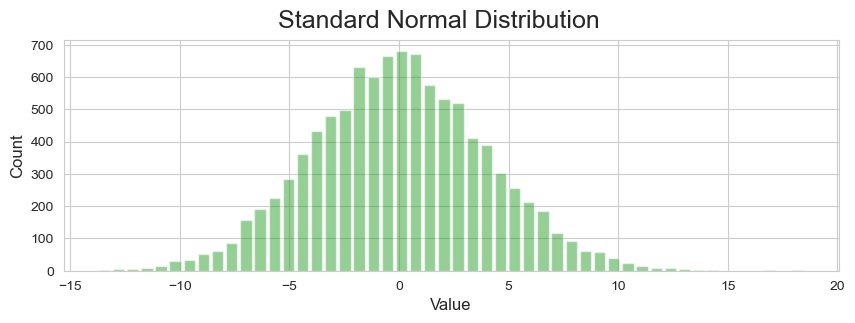

In [14]:
# The above function is used to plot the distribution of X     
plot_hist(X,50,'Standard Normal Distribution')

### Question 3

In order to show how the sample mean converges to the population mean ($\mu=0$) as sample size increases to $N=10,000$, we calculate the cummulative average of $\textbf{X}$ with increasing indices $i \in [0,N]$.

In [15]:
def find_cumm_avg(data):
    """
    This function takes a data array and finds its cummulative mean
    """
    return [np.mean(data[:i+1]) for i in range(len(data))]

In [16]:
# The above function is used to calculate the cummulative average (mean) for X
c_avg_std = find_cumm_avg(X)

### Question 4

Next, the cummulative standard error of $\textbf{X}$ is calculated for increasing indices $i \in [0,N]$. It is clear to see from the formula (and the plot in Question 6) that as the sample size increases, the standard error approaches $0$.

In [17]:
def find_std_error(data):
    """
    This function takes a data array and finds its cummulative standard error
    """
    return [np.std(data[:i+1])/np.sqrt(len(data[:i+1])) for i in range(len(data))]

In [18]:
# The above function is used to calculate the cummulative standard error for X
std_error = find_std_error(X)

### Question 5

According to the Normal Distribution's page on Wikipedia, the values of the distribution mean and median are equal to $\mu$.

In [19]:
mean = mu
median = mu

### Question 6

Now, we can plot the cummulative mean with standard error and distribution mean for $\textbf{X}$ as the sample size increases. To calculate the upper and lower bounds for the mean, the error is added and subtracted respectively from the mean, i.e., $UB = \bar{x}+\frac{err}{2}$ and $LB = \bar{x}-\frac{err}{2}$ so that the width of the error bar equals the standard error.

In [20]:
def bounds(avg, error):
    """
    This function takes the cummulative array and error value as arguments and returns upper- and lower-bound arrays.
    """
    UB = [i+(j/2) for i,j in zip(avg, error)]
    LB = [i-(j/2) for i,j in zip(avg, error)]
    return UB, LB

In [21]:
def plot(avg, UB, LB, dist_stat,label, dist_label, log_x=False, log_y=False,distb=True):
    
    """
    avg: cummulative array for a statistic 
    UB, LB: two arrays containing the upper and lower bounds on the value of the statistic 
    dist_stat: statistic value for the distribution 
    label: string containing information on the statistic being considered
    dist_label: string containing infor
    log_x,log_y: to put x/y axis a log scale
    """

    fig, ax = plt.subplots(figsize=(10,3))
    N = len(avg)

    ax.plot(UB, color='tab:orange', alpha=0.4, linewidth=1, label='Upper Bound')
    ax.plot(LB, color='black', alpha=0.4, linewidth=1, label='Lower Bound')
    ax.fill_between(np.arange(0,N),LB,UB, color='tab:red', alpha=0.2)
    
    label1 = 'Cumm. '+str(label)
    label2 = 'Dist. '+str(label)
    ax.plot(avg, linewidth=1, label=label1)
    if distb == True:
        ax.plot([dist_stat]*N, color='tab:green', alpha=0.8, linewidth=1,label=label2)

    ax.set_xlabel('Number of samples considered')
    ax.set_ylabel(label1)
    
    if log_x==True:
        ax.set_xscale('log')
    if log_y==True:
        ax.set_yscale('log')
    
    fig.legend(bbox_to_anchor=[1.06,0.8])
    label3 = 'Cummulative '+str(label)+ ' with error for '+str(dist_label)
    fig.suptitle(label3)
    plt.show()

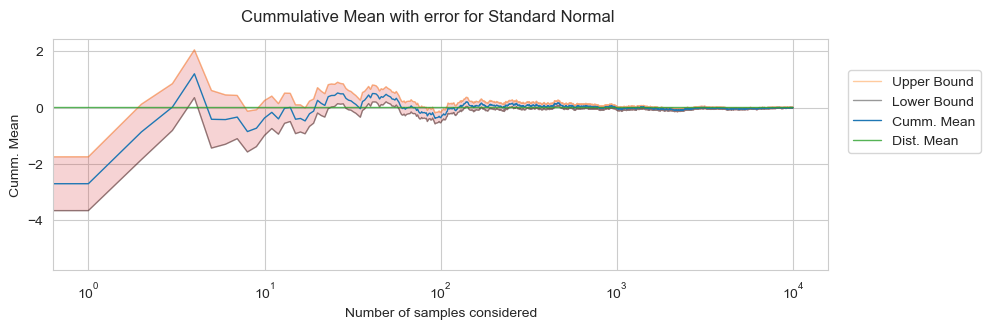

In [22]:
UB_std, LB_std = bounds(c_avg_std, std_error)
# Now we plot the graph showing the cummulative mean with error and the distribution mean
plot(c_avg_std, UB_std, LB_std, mean,'Mean', 'Standard Normal', log_x=True)

The x-axis of the plot above has been converted into a log-scale for easier visualization.

### Question 7

Next, we perform the same actions with the median statistic. First, the cummulative mean is calculated for $\textbf{X}$ for increasing indices.

In [23]:
def cumm_median(data):
    return [np.median(data[:i+1]) for i in range(len(data))]

In [24]:
c_median_std = cumm_median(X)

### Question 8

Next, the error of median is calulcated using a bootstrapping method, and the plot showing the cummulative median with its error and the distribution median is plot.

In [25]:
def med_bootstrap(data):
    """
    This function takes a data array and returns the upper and lower bounds 
    on its median statistic using bootstrapping and 90% confidence intervals.
    """
    median_error_UB = []
    median_error_LB = []

    for i in range(len(data)):
        medians = []
        j = 0
        while j <=100:
            array = np.random.choice(data[:i+1],len(data[:i+1]))
            medians.append(np.median(array))
            j +=1
        median_error_UB.append(np.percentile(medians,95)) # 90% confidence interval
        median_error_LB.append(np.percentile(medians,5))
    
    return median_error_UB, median_error_LB

In [26]:
median_error_UB_std, median_error_LB_std = med_bootstrap(X)

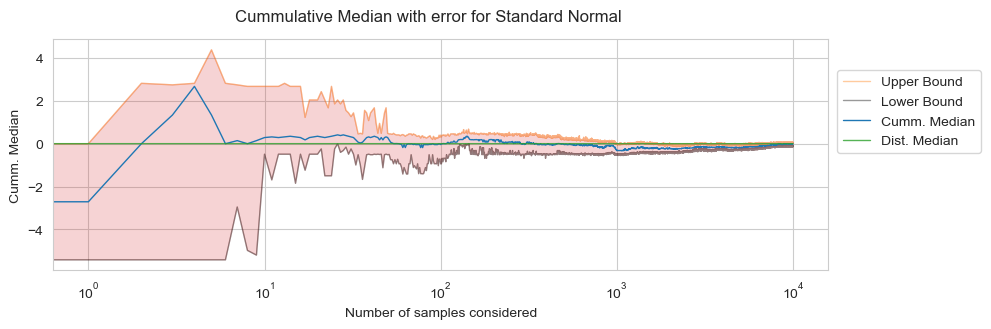

In [27]:
plot(c_median_std, median_error_UB_std, median_error_LB_std,median,'Median', 'Standard Normal',log_x=True)

The x-axis of the plot above has been converted into a log-scale for easier visualization.

### Question 9

To study the Law of Large numbers in heavy-tailed distributions, we sample the Pareto distribution.

In [28]:
N = 10000
a, m = 0.5, 1.0
P = (np.random.pareto(a, N) + 1) * m

### Question 10

This distribution is plot as a histogram where the x and y-axis have been given a logarithmic scale for a better visual and to show the power law distribution.

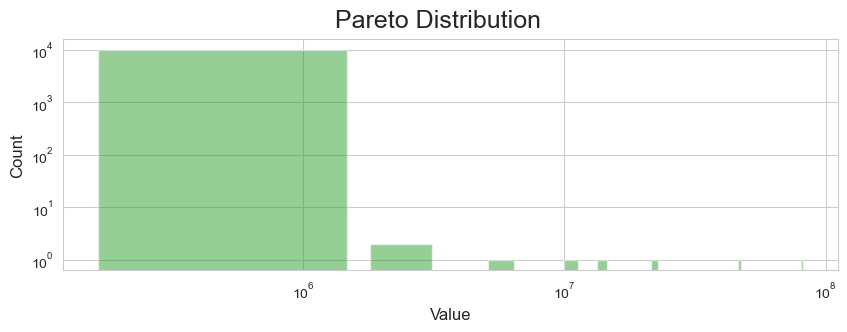

In [29]:
plot_hist(P,50,'Pareto Distribution', log=True,log_x=True)

Next, we find the cummulative mean and standard error of the sample mean for the Pareto distribution.

In [30]:
P_c_avg = find_cumm_avg(P)
P_std_error = find_std_error(P)

The upper and lower bounds of the mean for Pareto are calculated, and the graph with cummulative mean and error is plot. As the alpha value is less than 1, the expected mean of the distribution is equal to infinity and thus, the distribution mean is not visible in the plot.

In [31]:
UB_p, LB_p = bounds(P_c_avg, P_std_error)
P_mean = np.inf

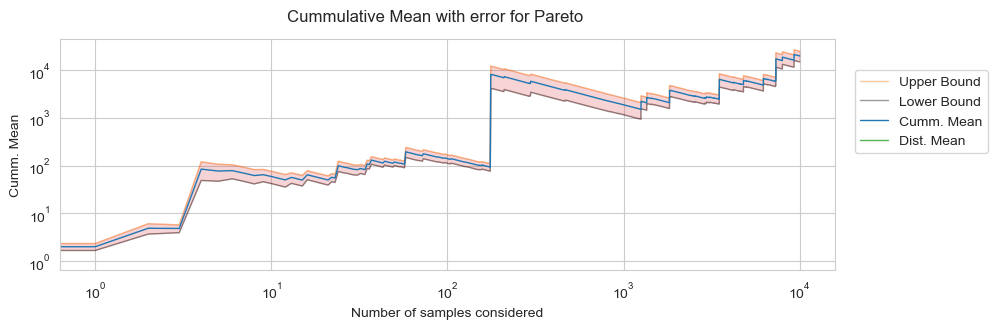

In [32]:
plot(P_c_avg, UB_p, LB_p, P_mean,'Mean','Pareto',log_x=True, log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

Next, we find the cummulative median for the distribution. To find the distribution median, the formula  $x_m\sqrt[\alpha]{2}$ is taken from Wikipedia.

In [33]:
P = np.array(P)
c_median_P = cumm_median(P)

In [34]:
median_error_UB_P, median_error_LB_P = med_bootstrap(P)

In [35]:
median_P = m*np.power(2,(1/a))

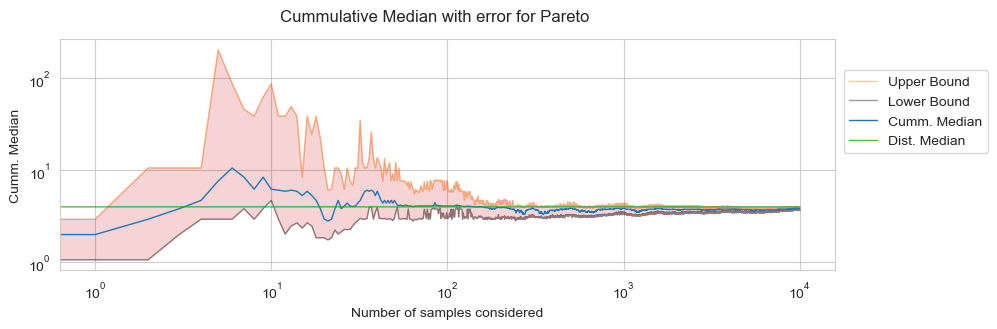

In [36]:
plot(c_median_P, median_error_UB_P, median_error_LB_P,median_P,'Median', 'Pareto', log_x=True,log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Question 11

Next, we sample a log-normal distribution to study another example of a heavy-tailed distribution. According to the question, we want to use numpy's np.random.standard_normal() function to create this array. In order to convert the standard normal distribution into a log-normal distribution with mean $\mu=0$ and standard deviation $\sigma=4$, we reverse Wikipedia's formula for logarithmic mean and standard deviation which are defined as $\mu_L = \exp\left(\mu+\frac{\sigma^2}{2}\right)$ and $\sigma_L=\sqrt{[\exp{(\sigma^2)}-1]\exp{(2\mu+\sigma^2)}}$ to calculate the appropriate mean and variance for the normal distributions. 

In [37]:
N = 10000
mu = 0.0000000000000000000000001 # division by zero is not possible
sigma = 4

mu_normal = np.log(mu**2 / np.sqrt(sigma**2 + mu**2))
sigma_normal = np.sqrt(np.log(1 + (sigma**2 / mu**2)))

L = np.exp(mu_normal + sigma_normal*np.random.standard_normal(N))

### Question 12

We repeat the same process as before for the log-normal distribution.

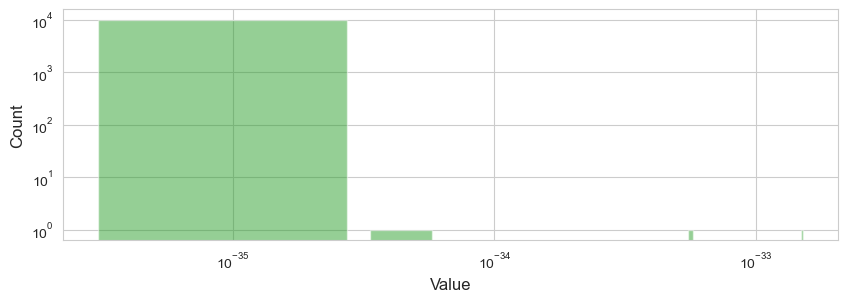

In [47]:
plot_hist(L,50,'',log=True,log_x=True)

The x- and y-axis of the plot above have been converted into a log-scale for easier visualization and to show the power-law distribution.

The cummulative average and standard error is found using the same process as before.

In [39]:
L_c_avg = find_cumm_avg(L)
L_c_error = find_std_error(L)

As stated before, the distrbution mean is found to be $\mu_L = \exp\left(\mu+\frac{\sigma^2}{2}\right)$ for Wikipedia. Moreover, the median is found to be $med_L = \exp{(\mu)}$.

In [40]:
L_mean = np.exp(mu_normal+(sigma_normal)**2/2)
L_med = np.exp(mu_normal)

We find the bounds on the cummulative mean using the standard error function, and plot it with the distribution mean.

In [41]:
UB_L, LB_L = bounds(L_c_avg, L_c_error)

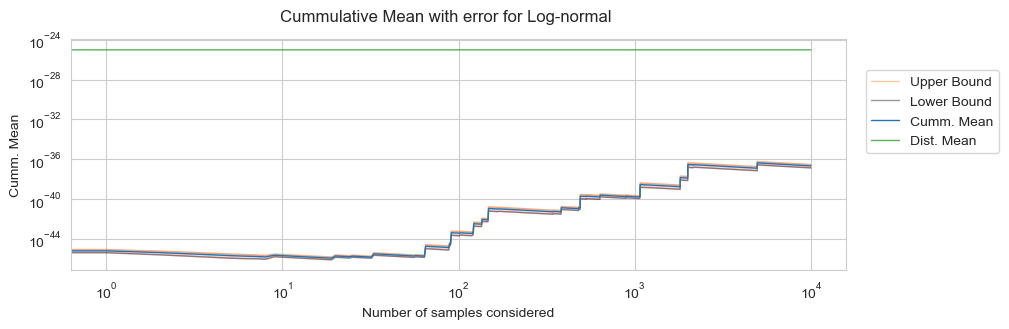

In [42]:
plot(L_c_avg, UB_L, LB_L, L_mean,'Mean','Log-normal',log_x=True, log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

Now we find the cummulative median and its upper and lower bounds.

In [43]:
L_c_med = cumm_median(L)

In [44]:
median_error_UB_L, median_error_LB_L = med_bootstrap(L)

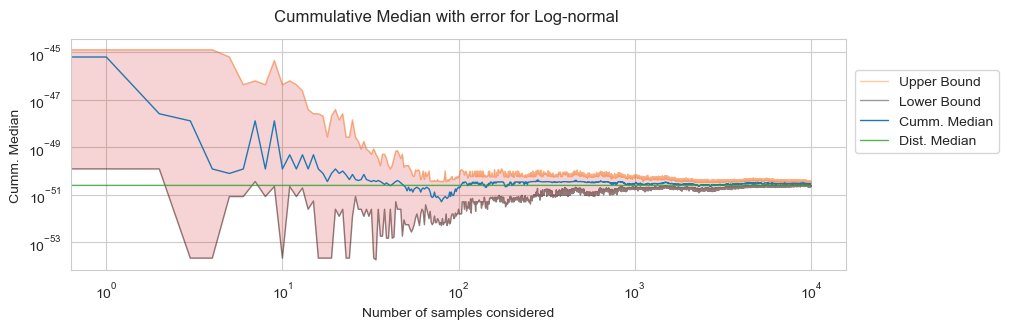

In [45]:
plot(L_c_med, median_error_UB_L, median_error_LB_L,L_med,'Median', 'Log-normal',log_x=True,log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Question 13

Let us consider the number of citations from papers in 2009.

In [100]:
df = pd.read_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Paper_dataset.csv')
cit_array = df[(df['year']==2009)]['citationCount']

In [101]:
N = len(cit_array)
print('Length of array is: ',N)

Length of array is:  23381


The mean and median number of citations in this distribution are calculated using numpy.

In [102]:
print('Mean of number of citations is', np.round_(np.mean(cit_array),2))
print('Median of number of citations is', np.round_(np.median(cit_array),2))

Mean of number of citations is 50.58
Median of number of citations is 9.0


We now extract a random sample of 10,000 points to further work with.

In [103]:
cit_array = np.random.choice(cit_array,10000,replace = False)

### Question 14

The study of the distribution is conducted for the array as well, and the x- and y-axis of the plot above have been converted into a log-scale for easier visualization and for showing the power law distribution that the citations count array follows.

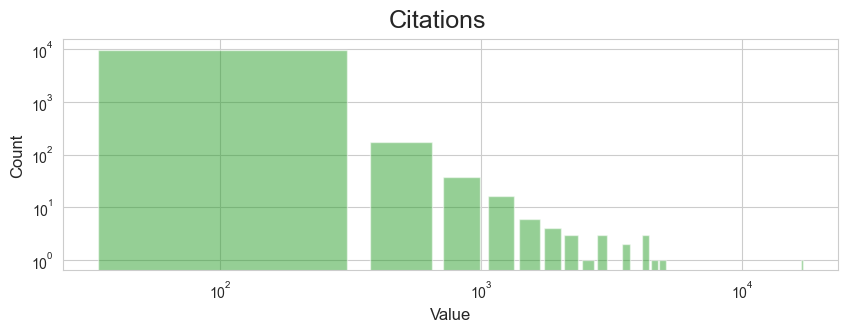

In [104]:
plot_hist(cit_array,50,'Citations',log=True,log_x=True)

In [105]:
C_c_avg = find_cumm_avg(cit_array)
C_c_error = find_std_error(cit_array)

We plot the cummulative mean with its error again (without considering the distribution mean).

In [106]:
UB_c, LB_c = bounds(C_c_avg, C_c_error)

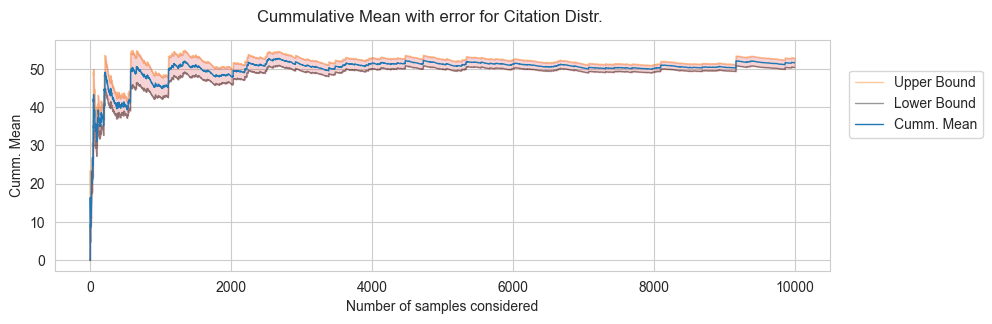

In [107]:
plot(C_c_avg, UB_c, LB_c,'','Mean', 'Citation Distr.', log_x=False, log_y=False,distb=False)

And we also plot the cummulative median with its bootstrapped error (without considering the distribution median).

In [108]:
C_c_med = cumm_median(cit_array)

In [109]:
median_error_UB_C, median_error_LB_C = med_bootstrap(cit_array)

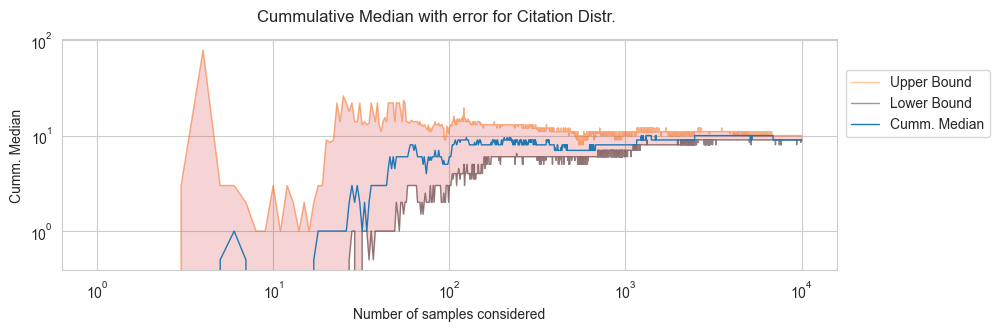

In [110]:
plot(C_c_med, median_error_UB_C, median_error_LB_C,'','Median', 'Citation Distr.', log_x=True, log_y=True,distb=False)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Comparing evolution of cummulative mean in Gaussian, Pareto, and Log Normal Distributions

The cummulative mean graph for the Gaussian distribution shows that as the sample size increases, the cummulative mean approaches the distribution mean with a relatively smooth curve as the error approaches zero. This result is expected becayse the Gaussian distribution is a symmetric distribution with the mean acting as the central tendency of the distribution. Thus, as the sample size increases, the cummulative mean will tend towards the distribution mean.

The distribution mean of the Pareto distribution was undefined (approaches infinity for values of alpha less than 1) and due to the power-law-tail, there is a lot of variability seen in the cummulative mean plot. The graph does, however, also show a slow rise of the sample mean in the direction of the distribution mean (=positive infinity).

The cummulative mean graph for the considered Log-normal distribution show a slow rise of the cummulative mean towards the distribution mean. This is because, this distribution has a long tail towards the positive side and extreme values in the tail can have a disproportionate effect on the mean - causing it to be greater than the median. Thus, like Pareto, the log-normal distribution requires a much larger sample size for the LoLN to apply.

### Comparing evolution of cummulative median in Gaussian, Pareto, and Log-normal Distributions

The cummulative median graph shows a smooth convergence of sample median to distribution median as the sample size increases. As with cummulative mean, this is because Gaussian distribution is a symmetric distribution with median also displaying the central tendency of the distribution.

It can also be seen that the cummulative sample medians for Pareto and Log-normal distributions both converge to the distribution median values. This is because, from a statistical point of view, median is just the middle value of the distribution and is not affected by extreme values in the same way that the mean is. This is why median is accepted as a more robust measure of central tendency.

In conclusion, while working with skewed distributions, median should be prefered as a descriptive statistic over the mean.

### Studying the distribution of the citation counts

The histogram plotting the number of citations shows a power-law distribution with a right skew (also shows by the fact that the mean is relatively greater than the median).

The implication of this phenomena implies that the majority of papers get around 8 citations (using median as an indicator of central tendency) and very few papers get more than 40,000 citations. This shows the disproportionality that occurs in real-world data.

Another implication is that we're seeing a 'rich-get-richer' phenomena here as papers with a high number of citations tend to be found and cited more often - which leads to a power law emegerging. This is similar to the network example in the lectures where popularity based connections led to popular people becoming very popular and most people staying relatively unpopular.

### Summary: Take home messages of this exercise

There are two important take home messages from this exercise:

- Median should be used as an indicator of central tendency over mean when it comes to power-law/heavily skewed distributions.
- The number of citation counts of papers is an example of a real-world dataset which follows a power-law distribution because of the 'rich-get-richer' phenomenon.